# **Introducción**

#### Sabemos que kMeans es un método de clasificación (clustering) no supervisado que nos ayuda a encontrar subgrupos de datos similares dentro de un conjunto de datos. Veamos ahora el efecto que puedan tener diferentes técnicas de reducción de dimensionalidad, Autoencoders y PCA, en la calidad de dichos subgrupos.

La página inicial de Kaggle de donde proceden dichos datos se desactualizó, pero mientras la acutalizan, el archivo de los datos estará en Canvas.

El archivo consta de 15,000 registros con 9 factores para un problema de ambiente de trabajo en una organización (entre ellos el problema de rotación de personal como ya estudiamos en semanas anteriores) con variables numéricas y categóricas.

La idea es usar técnicas de Autoencoders y PCA, en combinación con el método de KMeans, para encontrar subgrupos o cúmulos de personas que nos den información sobre el ambiente de trabajo dentro de dicha organización.

Las técnicas que aplicaremos son técnicas no supervisadas, ya que no tenemos la información en relación a un problema de clasificación o regresión.



Así, usaremos técnicas de reducción de dimensionalidad para identificar subgrupos similares de empleados a través de información proporcionada por el archivo proveniente de recursos humanos. Primero vamos a identificar los subgrupos y después vamos predecir qué datos están en cada subgrupo.

Para entender lo que nos dicen dichos subgrupos desde un punto de vista de negocio, necesitamos analizar dichos subrupos con respecto a los factores iniciales. Es decir, ¿qué tienen en común los empleados que están en un mismo subgrupo?

Recuerda que la manera en que funciona el método del codo (elbow method) para seleccionar el mejor número de subrupos en la técnica de kMeans, es buscando la cantidad de cúmulos que nos lleve a la suma más baja de distancias al cuadrado (llamada "inercia"), es decir, donde la inercia no sufra cambios importantes al seguir aumentando la cantidad de cúmulos.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model, load_model

from keras.optimizers import SGD

from sklearn.preprocessing import OrdinalEncoder

# comentemos por el momento los posibles Warnings:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# Google Colab Mount
drive.mount('/content/drive')
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/TC4030 - IAAA/Semana_9"
os.chdir(DIR)

Mounted at /content/drive


# **Funciones para gráficas de la última parte de esta atcividad.**

In [ ]:
# Esta celda contiene las funciones para generar varios de los
# gráficos que requeriremos en esta actividad.

# Definimos la función de gráficos con datos numéricos:

def mi_scatterplotPCAEncoder(perfil_Zencoder, perfil_pca, fact1, fact2):

  plt.figure(figsize=(15,10))
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,15))

  sns.scatterplot(data=perfil_Zencoder,
                  x= fact1,
                  y= fact2,
                  hue='autoencoder_clusters',
                  s=85,
                  alpha=0.4,
                  palette='bright',
                  ax=ax1
                  ).set_title('(AutoEncoder) Cúmulos',fontsize=18)

  sns.scatterplot(data=perfil_pca,
                  x=fact1,
                  y=fact2,
                  hue='pca_clusters',
                  s=85,
                  alpha=0.6,
                  palette='bright'
                  ).set_title('(PCA) Cúmulos',fontsize=18)



# Definimos la función de gráficos con variables categóricas:

def mi_catplotPCAEncoder(perfil_Zencoder, perfil_pca, fact1, fact2):

  plt.figure(figsize=(15,10))
  fig = plt.subplots(1,2, figsize=(20,15))

  ax1 = sns.catplot(data=perfil_Zencoder,
                    x= fact1,
                    y= fact2,
                    hue='autoencoder_clusters',
                    jitter=0.6,
                    s=20,
                    alpha=0.6,
                    palette='bright',
                    legend_out=True
                    )

  ax2 = sns.catplot(data=perfil_pca,
                    x=fact1,
                    y=fact2,
                    hue='pca_clusters',
                    jitter=0.6,
                    s=20,
                    alpha=0.6,
                    palette='bright',
                    legend_out=True
                    )

  ax1.fig.suptitle('(AutoEncoder) Cúmulos', fontsize=16,)
  ax2.fig.suptitle('(PCA) Cúmulos', fontsize=16)
  plt.close(1)
  plt.close(2)

# **Cargando la información**

In [ ]:
# Cargamos los datos:
data = pd.read_csv("hr_autoencoders.csv",sep=',',header='infer')
print(data.shape)
data.head().T

(15000, 9)


0      1       2       3      4
satisfaction_level      0.09   0.38     0.8    0.11   0.72
last_evaluation         0.36   0.53    0.86    0.88   0.87
number_project             2      2       5       7      5
average_montly_hours      96    157     262     272    223
time_spend_company         2      3       6       4      5
Work_accident              0      0       0       0      0
promotion_last_5years      0      0       0       0      0
sales                  sales  sales   sales   sales  sales
salary                   low    low  medium  medium    low

La información sobre cada variable es la siguiente:

*   #### **satisfaction_level:** Nivel de satisfacción del empleado dentro de la organización en la última encuesta realizda. Escala de 0 a 1, donde 1 es lo mejor.

*   #### **last_evaluation:** Calificación del desempeño del empleado en la última evaluación realizada por la empresa. Escala de 0 a 1, donde 1 es lo mejor.

*   #### **number_project:** Número promedio de proyectos en los que usualmente está involucrado dentro de la empresa.

*   #### **average_montly_hours:** Horas mensuales promedio de trabajo en la empresa.

*   #### **time_spend_company:** Cantidad de años dentro de la empresa.

*   #### **Work_accident:** Si ha tenido (1) o no (0) un accidente dentro de la empresa.

*   #### **promotion_last_5years:** Si ha sido promovido (1) o no (0) dentro de la empresa en los últimos 5 años.

*   #### **sales:** Área a la que pertenece dentro de la empresa: sales, technical, support, IT, product_mng, marketing, RandD, accounting, hr, management.

*   #### **salary:** Nivel de salario del empleado: low, medium, high.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     15000 non-null  float64
 1   last_evaluation        15000 non-null  float64
 2   number_project         15000 non-null  int64  
 3   average_montly_hours   15000 non-null  int64  
 4   time_spend_company     15000 non-null  int64  
 5   Work_accident          15000 non-null  int64  
 6   promotion_last_5years  15000 non-null  int64  
 7   sales                  15000 non-null  object 
 8   salary                 15000 non-null  object 
dtypes: float64(2), int64(5), object(2)
memory usage: 1.0+ MB


Las variables numéricas son: satisfaction_level, last_evaluation, number_project, average_montly_hours, time_spend_company.

Las variables categóricas binarias son: Work_accident, promotion_last_5years.

Varaible categórica nominal: sales.

Variable categórica ordinal: salary.

#### **Apliquemos las transformaciones correspondientes a cada una de estas variables**

In [ ]:
num_list = ['satisfaction_level', 'last_evaluation', 'number_project',
           'average_montly_hours', 'time_spend_company']   # [0,1,2,3,4]

cat_list = ['Work_accident','promotion_last_5years','sales','salary']   # [5,6,7,8]

dftodos = data[num_list + cat_list]
print(dftodos.shape)
dftodos.head().T

(15000, 9)


0      1       2       3      4
satisfaction_level      0.09   0.38     0.8    0.11   0.72
last_evaluation         0.36   0.53    0.86    0.88   0.87
number_project             2      2       5       7      5
average_montly_hours      96    157     262     272    223
time_spend_company         2      3       6       4      5
Work_accident              0      0       0       0      0
promotion_last_5years      0      0       0       0      0
sales                  sales  sales   sales   sales  sales
salary                   low    low  medium  medium    low

In [ ]:
# Escalamos las variables numéricas antes de aplicar KMeans,
# ya que este es muy sensible a la escala:

X_Tnum = dftodos.copy()

scaler = StandardScaler()
scaler.fit(dftodos[num_list])
X_Tnum[num_list] = scaler.transform(dftodos[num_list])

df_Tnum = pd.DataFrame(X_Tnum, columns=dftodos.columns)

df_Tnum.head().T

0         1         2         3         4
satisfaction_level    -2.102542 -0.936248  0.752869 -2.022108  0.431132
last_evaluation       -2.080109 -1.087016  0.840752  0.957587   0.89917
number_project         -1.46271  -1.46271  0.971174  2.593762  0.971174
average_montly_hours   -2.10309 -0.881799  1.220424  1.420635  0.439598
time_spend_company    -1.026055 -0.341166  1.713502  0.343723  1.028612
Work_accident                 0         0         0         0         0
promotion_last_5years         0         0         0         0         0
sales                     sales     sales     sales     sales     sales
salary                      low       low    medium    medium       low

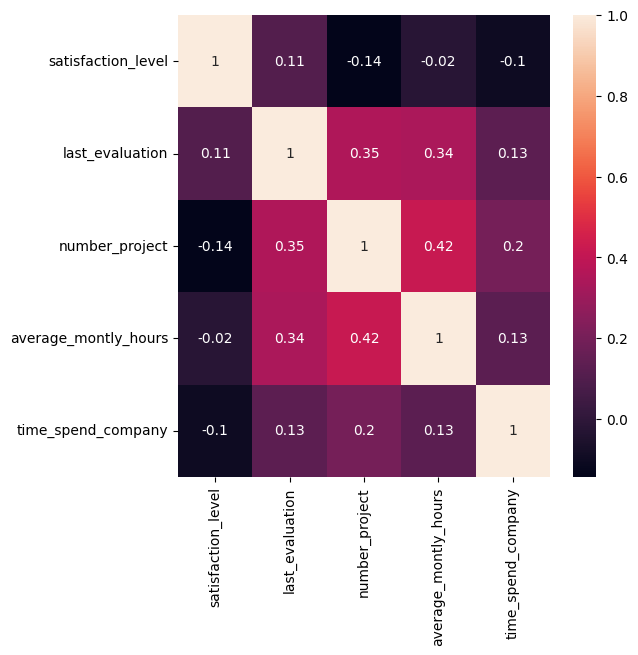

In [ ]:
# La matriz de correlación de las varaibles numéricas nos indica que no se
# observan correlaciones altas entre ellas, es decir, se tiene una
# multicolinealidad baja:

correlations = df_Tnum[num_list].corr()
f, ax = plt.subplots(figsize = (6,6))
sns.heatmap(correlations, annot = True);

# **KPrototype : KMeans para variables numéricas y categóricas.**



#### **Recordemos que KMeans es una técnica para variables numéricas ya que está basada en la distancia (por ejemplo, euclideana) entre puntos. Para el caso de variables categóricas, dicha "distancia" será ahora la Moda y la similitud será la diferencia entre los distintos niveles.**

#### **Para ello debemos usar la librería KModes para datos solamente categóricos, o bien KPrototype, para conjunto de datos mixtos (numéricos y categóricos).**

#### **Toma en cuenta que debido al proceso de estar manejando variables numéricas y categóricas, el método de KPrototype puede tomar varios minutos en terminarse.**

In [ ]:
!pip install kmodes   # Debemos instalar KModes, que necesitaremos para KPrototype.

In [ ]:
from kmodes.kprototypes import KPrototypes

In [ ]:
df_Tnum.head().T

0         1         2         3         4
satisfaction_level    -2.102542 -0.936248  0.752869 -2.022108  0.431132
last_evaluation       -2.080109 -1.087016  0.840752  0.957587   0.89917
number_project         -1.46271  -1.46271  0.971174  2.593762  0.971174
average_montly_hours   -2.10309 -0.881799  1.220424  1.420635  0.439598
time_spend_company    -1.026055 -0.341166  1.713502  0.343723  1.028612
Work_accident                 0         0         0         0         0
promotion_last_5years         0         0         0         0         0
sales                     sales     sales     sales     sales     sales
salary                      low       low    medium    medium       low

Vemos la información de las variables categóricas:

In [ ]:
df_Tnum['Work_accident'].value_counts()

Work_accident
0    12831
1     2169
Name: count, dtype: int64

In [ ]:
df_Tnum['promotion_last_5years'].value_counts()

promotion_last_5years
0    14681
1      319
Name: count, dtype: int64

In [ ]:
df_Tnum['sales'].value_counts()

sales
sales          4141
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64

In [ ]:
df_Tnum['salary'].value_counts()

salary
low       7317
medium    6446
high      1237
Name: count, dtype: int64

#### **Método de inicialización de KModes y KPrototype:**

Existen varias técnicas de inicialización de las variables catagóricas, en particular usaremos la llamada "Huang", la cual selecciona los primeros "K" registros distintos para iniciar con "K-Modes". Recordemos que en KModes se utuliza la moda en lugar del promedio aritmético que se aplica en las numéricas.

La "distancia" o "diferencia" entre un dato y un centroide será la suma de la diferencia de la parte numérica más la parte categórica. La parte numérica se calcula con la distancia euclideana usual sobre las coordenadas numéricas. Y la parte categórica mide la distancia de un dato a un centroide, como la cantidad de coordenadas categóricas diferentes dentre el dato y el centroide.

Las variables categóricas no requieren ser transformadas, solamente hay que indicar cuáles son y el algoritmo se encargará de tratarlas como tales.

Puedes consultar la siguiente liga de la documentación:

https://kprototypes.readthedocs.io/en/latest/api.html

Text(0, 0.5, 'Inercia')

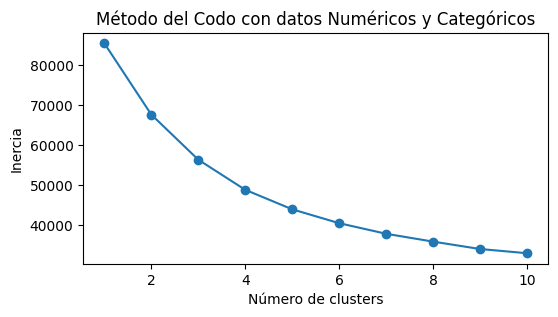

In [ ]:
# Apliquemos el método de KMeans para datos mixtos (numéricos y categóricos)

#                                                            ...esta celda tarda 45 mins aprox en Google-Colab ...

ssecat = []    # Suma del cuadrado de los errores numéricos y categóricos .

k_list = range(1, 11)

cat_cols = [5,6,7,8]  # cat_list

for k in k_list:
    kp = KPrototypes(n_clusters=k, init='Huang', n_init=5)    # Inicializamos KMeans-con-varaibles-Mixtas
    kp.fit(df_Tnum , categorical=cat_cols)     # debemos indicarle cuáles son las variables categóricas.
    ssecat.append([k, kp.cost_])   # Calculamos la incercia de cada dato, numérica y categórica conjunta.


oca_results_scale = pd.DataFrame({'Cluster': range(1,11), 'SSE-CAT': ssecat})

plt.figure(figsize=(6,3))
plt.plot(pd.DataFrame(ssecat)[0], pd.DataFrame(ssecat)[1], marker='o')
plt.title('Método del Codo con datos Numéricos y Categóricos')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')

# **Ejercicio - 1:**

De acuerdo con el método gráfico del codo podemos observar que la inercia presenta decrementos importantes con los primeros numeros de clusters hasta el 5. A partir de ahí los decrementos cambian en magnitudes más pequeñas conforme aumentan los clusters, por ello se toma el **5**, aunque cabe mencionar que aun el 4 podría ser un buen número de clusters, sin embargo, es mejor escoger el 5 porque presenta una inercia menor.

In [ ]:
# Selecciona el valor del entero "k" de kMeans, la cantidad de subgrupos o
# cúmulos (clusters) que creas adecuado siguiendo la técnica del codo
# y de acuerdo a la gráfica obtenida en la celda anterior:

k_clusters_KProto = 5

Recordemos que el Autoencoder es una red neuronal artificial, por lo que ahora sí requerimos transformar también las variables categóricas.

In [ ]:
# Escalando la variable Ordinal:

df_Tnumord = df_Tnum.copy()

ordenc = OrdinalEncoder()
df_Tnumord[['salary']] = ordenc.fit_transform(df_Tnumord[['salary']])

df_Tnumord.head().T

0         1         2         3         4
satisfaction_level    -2.102542 -0.936248  0.752869 -2.022108  0.431132
last_evaluation       -2.080109 -1.087016  0.840752  0.957587   0.89917
number_project         -1.46271  -1.46271  0.971174  2.593762  0.971174
average_montly_hours   -2.10309 -0.881799  1.220424  1.420635  0.439598
time_spend_company    -1.026055 -0.341166  1.713502  0.343723  1.028612
Work_accident                 0         0         0         0         0
promotion_last_5years         0         0         0         0         0
sales                     sales     sales     sales     sales     sales
salary                      1.0       1.0       2.0       2.0       1.0

Las variables binarias las dejaremos como tales y la nominal aplicaremos one-hot-encoding con el método get_dummies() de Pandas:

In [ ]:
X_Tnumordnom = df_Tnumord.copy()   # transformemos la variable Nominal con las Dummies de Pandas.

X_Tnumordnom = pd.get_dummies(X_Tnumordnom, columns=['sales'], dtype=int, drop_first=True)

df_Tnumordnom = pd.DataFrame(X_Tnumordnom)

print(df_Tnumordnom.shape)
df_Tnumordnom.head().T

(15000, 17)


0         1         2         3         4
satisfaction_level    -2.102542 -0.936248  0.752869 -2.022108  0.431132
last_evaluation       -2.080109 -1.087016  0.840752  0.957587  0.899170
number_project        -1.462710 -1.462710  0.971174  2.593762  0.971174
average_montly_hours  -2.103090 -0.881799  1.220424  1.420635  0.439598
time_spend_company    -1.026055 -0.341166  1.713502  0.343723  1.028612
Work_accident          0.000000  0.000000  0.000000  0.000000  0.000000
promotion_last_5years  0.000000  0.000000  0.000000  0.000000  0.000000
salary                 1.000000  1.000000  2.000000  2.000000  1.000000
sales_RandD            0.000000  0.000000  0.000000  0.000000  0.000000
sales_accounting       0.000000  0.000000  0.000000  0.000000  0.000000
sales_hr               0.000000  0.000000  0.000000  0.000000  0.000000
sales_management       0.000000  0.000000  0.000000  0.000000  0.000000
sales_marketing        0.000000  0.000000  0.000000  0.000000  0.000000
sales_product_mng      0.000000  0.000000  0.000000  0.000000  0.000000
sales_sales            1.000000  1.000000  1.000000  1.000000  1.000000
sales_support          0.000000  0.000000  0.000000  0.000000  0.000000
sales_technical        0.000000  0.000000  0.000000  0.000000  0.000000

# **Modelo AUTOENCODER**

In [ ]:
# Definamos una arquitectura Autoencoder de manera usual para el caso de
# búsqueda de conglomerados: iniciar en el Encoder incrementando las primeras
# capas densas ocultas para deshacer lo mayor posible la dependencia de los
# factores, para posteriormente proyectarlos al espacio latente Z de menor
# dimensión. Cuando decimos de menor dimensión, es con respecto a la dimensión
# de los factores de entrada. En particular usaremos aproximadamente la mitad
# de los nodos/factores de entrada (que son 17).
# Posteriormente el Decoder será un espejo del
# Encoder, salvo alguna capa que podemos eliminar para que no se tenga una
# simetría completa y obtengamos algo más que simplemente vectores muy
# similares a los iniciales de entrada.
# Cada capa densa la inicializamos con Xavier-Glorot y usamos ReLU como
# función de activación.
# Finalmente usamos Adam como optimizador y la suma de cuadrados para la
# función de costo.

input_factors = df_Tnumordnom.shape[1]  # cantidad de factores en los datos de entrada.
int_z_latent = 8     # Dimensión del espacio latente Z.
encoding_dim = k_clusters_KProto  # valor k que determinaste en el método del codo del Ejercicio 1.

input_df = Input(shape=(input_factors, ))

# Capas del ENCODER:
x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(400, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(400, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(1500, activation='relu', kernel_initializer='glorot_uniform')(x)

# ESPACIO LATENTE Z:
encoded = Dense(int_z_latent, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)

# Capas del DECODER:
x = Dense(1500, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(400, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense( input_factors, kernel_initializer = 'glorot_uniform')(x)

# Generamos los modelos Autoencoder y Encoder:
autoencoder = Model(input_df, decoded)  # Modelo Autoencoder: (entrada de datos iniciales) + (Encoder) + (espacio-Z-latente) + (Decoder).
encoder = Model(input_df, encoded)      # Modelo Encoder:  (entrada de datos iniciales) + (Encoder) + (espacio-Z-latente).

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Pasamos al proceso de entrenamiento del Autoencoder.
# Aunque solo requeriremos en este ejercicio el Encoder, en el proceso debemos
# también generar el Decoder:

autoencoder.fit(df_Tnumordnom, df_Tnumordnom, batch_size=256, epochs = 30, verbose = 1)


Epoch 1/30
59/59 [==============================] - 6s 76ms/step - loss: 0.2615
Epoch 2/30
59/59 [==============================] - 6s 109ms/step - loss: 0.1706
Epoch 3/30
59/59 [==============================] - 7s 110ms/step - loss: 0.1446
Epoch 4/30
59/59 [==============================] - 6s 100ms/step - loss: 0.1213
Epoch 5/30
59/59 [==============================] - 8s 137ms/step - loss: 0.1078
Epoch 6/30
59/59 [==============================] - 6s 106ms/step - loss: 0.1011
Epoch 7/30
59/59 [==============================] - 10s 163ms/step - loss: 0.0956
Epoch 8/30
59/59 [==============================] - 7s 111ms/step - loss: 0.0924
Epoch 9/30
59/59 [==============================] - 6s 103ms/step - loss: 0.0891
Epoch 10/30
59/59 [==============================] - 5s 89ms/step - loss: 0.0873
Epoch 11/30
59/59 [==============================] - 3s 50ms/step - loss: 0.0857
Epoch 12/30
59/59 [==============================] - 3s 51ms/step - loss: 0.0834
Epoch 13/30
59/59 [=========

In [ ]:
pred_Z_latente = encoder.predict(df_Tnumordnom)   # generamos los vectores en el espacio latente Z a la salida del Encoder.

469/469 [==============================] - 1s 3ms/step


In [ ]:
pred_Z_latente.shape   # dimensión de los vectores en el espacio latente

(15000, 8)

Ahora, con base a los vectores latentes obtenidos con el Autoencoder, apliquemos kMeans (con el método usual para variables numéricas) para seleccionar cuántos cúmulos podríamos generar con estos vectores para obtener información sobre los empleados de la empresa y su potencial salida de la misma.

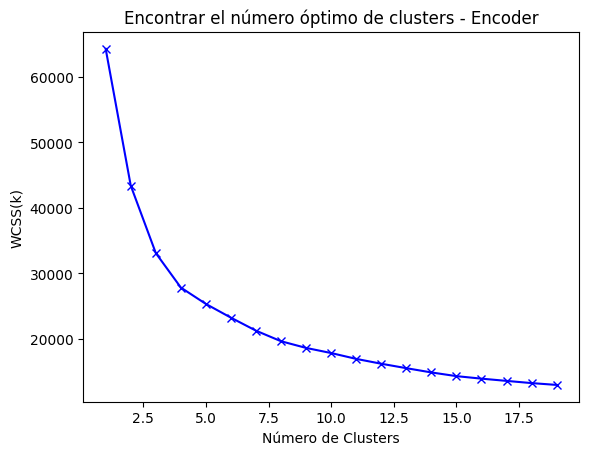

In [ ]:
scores_Z = []                                          #    tarda menos de 1 min

range_values = range(1,20)

for i in range_values:
    kmeans = KMeans(n_clusters = i, n_init=10)
    kmeans.fit(pred_Z_latente)
    scores_Z.append(kmeans.inertia_)   # WCSS : within-cluster sum of square


plt.plot(range_values, scores_Z, 'bx-')
plt.title("Encontrar el número óptimo de clusters - Encoder")
plt.xlabel("Número de Clusters")
plt.ylabel("WCSS(k)")
plt.show()

Basándonos en el método del codo, podríamos decir que 5, 6 o 7 cúmulos serían adecuados.

Veamos que valor de K obtenemos con la técnica Silhouette.

Si no conoces esta técnica, puedes consultar la documentación correspondiente en la siguiente liga:

https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html


In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

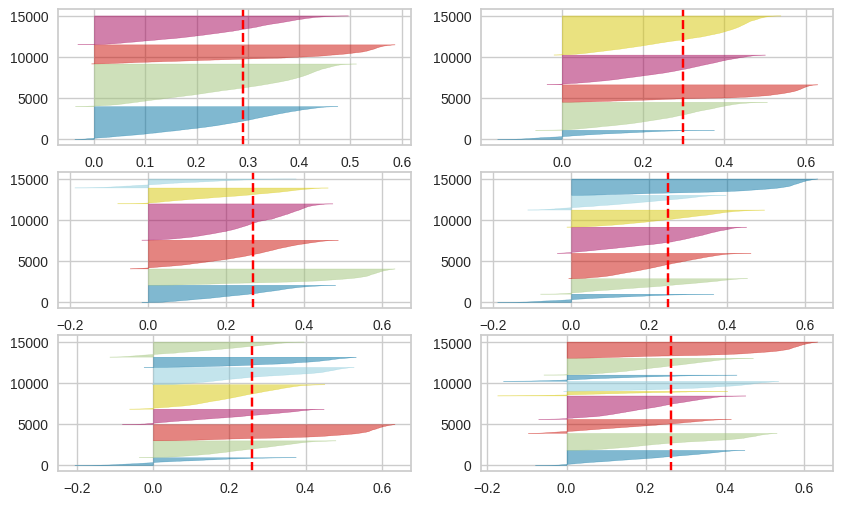

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10,6))            # tarda se 1 a 2 mins

for i in [4,5,6,7,8,9]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=7)
    q, mod = divmod(i-2, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(pred_Z_latente)

# **Ejercicio - 2:**

De acuerdo con la gráfica de codo podemos observar que los cambios en las magnitudes de la metrica WCSS comienzan a diminuir drasticamente a partir de 5 clusters, después de 5 clusters los cambios son cada vez menores en menor magnitud aunque también 6 o 7 clusters aun se podrían considerar como óptimos. Adicionalmente, al obsrvar las gráficas de la técnica Silhouette, podemos confirmar que 5 clusters funcionan como óptimos al observar que las densidades de las 5 siluetas están definidas, esto es, hay una separación y cohesión de los clústeres en los datos.

In [ ]:
# Selecciona el valor del entero "k" del número de cúmulos con base a lo
# observado los gráficoa de la técnica del codo y de silhouette.
# Observa que no necesriamente deben coincidir los valores observados
# por ambos métodos, por lo que deberás elegir el que consideres
# más adecuado:
k_clusters_Z_latente = 5

In [ ]:
km_Z_latent = KMeans(n_clusters= k_clusters_Z_latente,    # valor que seleccionaste en el Ejercicio 2.
                     n_init=10,    # número de veces que selecciona vectores de inicialización y se queda con el de menor inercia.
                     max_iter=500,
                     init='k-means++').fit(pred_Z_latente)

labels_Z_latent = km_Z_latent.labels_    # etiquetas para cada registro-renglón de los datos de entrada.

In [ ]:
pd.DataFrame(labels_Z_latent).value_counts()   # Tamaño de los clusters obtenidos con el método del Autoencoder.

3    4755
4    3607
0    3403
2    2109
1    1126
Name: count, dtype: int64

In [ ]:
# Apliquemos PCA ahora a los vectores latentes obtenidos para proyectarlos y
# visualizarlos en un espacio de dimensión 2:

pca = PCA(n_components=2)
princ_comp = pca.fit_transform(pred_Z_latente)
pca_df = pd.DataFrame(data = princ_comp, columns=["pca1", "pca2"])
pca_df = pd.concat([pca_df, pd.DataFrame({"cluster":labels_Z_latent})], axis = 1)
pca_df.head(3)

pca1      pca2  cluster
0  3.688800  0.596334        2
1  2.537280 -0.545839        2
2 -1.670245 -0.389115        3

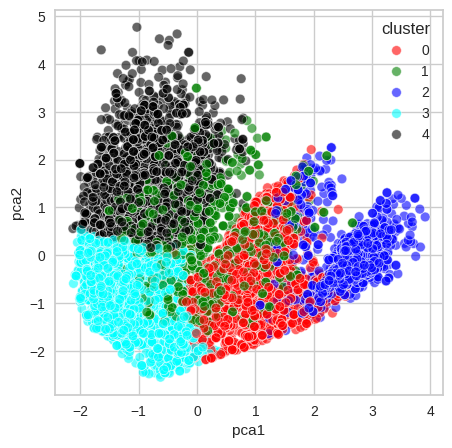

In [ ]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(x="pca1", y = "pca2", hue="cluster", data = pca_df,
                     alpha=0.6,
                     palette=["red", "green", "blue","cyan", "black",'pink','orange', "yellow"])
plt.show()

In [ ]:
# Concatenamos la información de las etiquetas de cada registro del dataframe de
# entrada indicando además en qué cúmulo se encuentran.
# Es importante tener los valores iniciales sin transformar con la información
# de a qué cumulo pertenece para poder darles un mejor significado desde el
# punto de vista del negocio, en este caso sobre cada factor y su impacto en
# la posible salida de un empleado.

cluster_Z_latent_perfiles = pd.concat([dftodos, pd.DataFrame({'autoencoder_clusters':labels_Z_latent})], axis=1 )

cluster_Z_latent_perfiles.head().T

0      1       2       3      4
satisfaction_level      0.09   0.38     0.8    0.11   0.72
last_evaluation         0.36   0.53    0.86    0.88   0.87
number_project             2      2       5       7      5
average_montly_hours      96    157     262     272    223
time_spend_company         2      3       6       4      5
Work_accident              0      0       0       0      0
promotion_last_5years      0      0       0       0      0
sales                  sales  sales   sales   sales  sales
salary                   low    low  medium  medium    low
autoencoder_clusters       2      2       3       3      3

# **PCA - Análisis de Componentes Principales**



Aplicaremos ahora la técnica PCA a los datos iniciales para generar igualmente cúmulos y compararlo con lo obtenido con la técnica de Autoencoder previamente vista. Esta técnica es más conocida y generalemente la que se aplica en primera instancia en un problema de agrupamiento (clustering).

En este caso lo haremos tomando directamente las decisiones sobre los gráficos que estarmos generando:

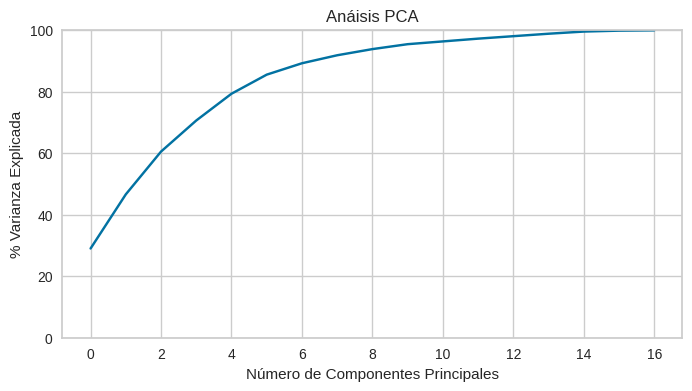

In [ ]:
# Consideremos el DataFrame con los 17 vectores transformados
# y apliquemos PCA con todos ellos para ver qué cantidad de
# componenes principales podrían ser suficientes para un análisis
# de relación factores y cúmulos que formaremos:

pca = PCA(n_components= df_Tnumordnom.shape[1], random_state=5)
pca.fit(df_Tnumordnom)

variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)

plt.figure(figsize=(8,4))
plt.ylabel('% Varianza Explicada')
plt.xlabel('Número de Componentes Principales')
plt.title('Anáisis PCA')
plt.ylim(0,100.1)
plt.plot(var);

#### **Vemos que con 4 o 6 componentes principales se explica aproximadamente entre el 80% y 90% de su varianza.**

#### **Selecconaremos el valor de 6 componentes principales (que implica cerca del 90% de la variabilidad de los datos) para fines de este ejercicio y a continuación veamos cuántos cúmulos podrían ser adecuados usar al aplicar el método de conglomerados (clustering).**

Text(0, 0.5, 'Inercia')

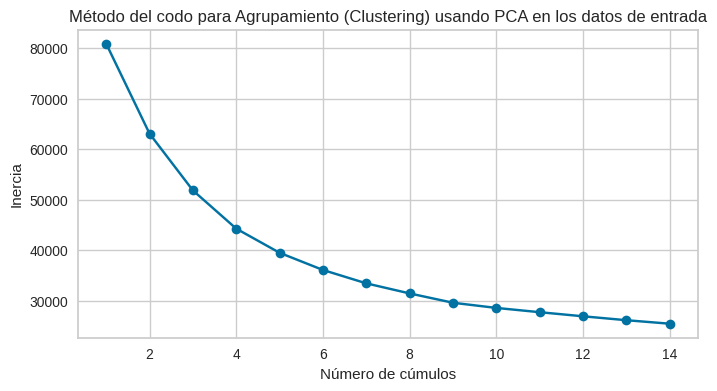

In [ ]:
                                                            #  tarda menos de 1 min
pca = PCA(n_components=6)    # seleccionamos 6 componentes principales que tienen un 90% de la varibilidad total
pca_T = pca.fit_transform(df_Tnumordnom)
pca_df_T = pd.DataFrame(pca_T, columns=['pc1','pc2','pc3','pc4','pc5','pc6'])


sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k,n_init=7,random_state=7)
    km.fit(pca_df_T)
    sse.append([k, km.inertia_])

pca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(8,4))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Método del codo para Agrupamiento (Clustering) usando PCA en los datos de entrada')
plt.xlabel('Número de cúmulos')
plt.ylabel('Inercia')

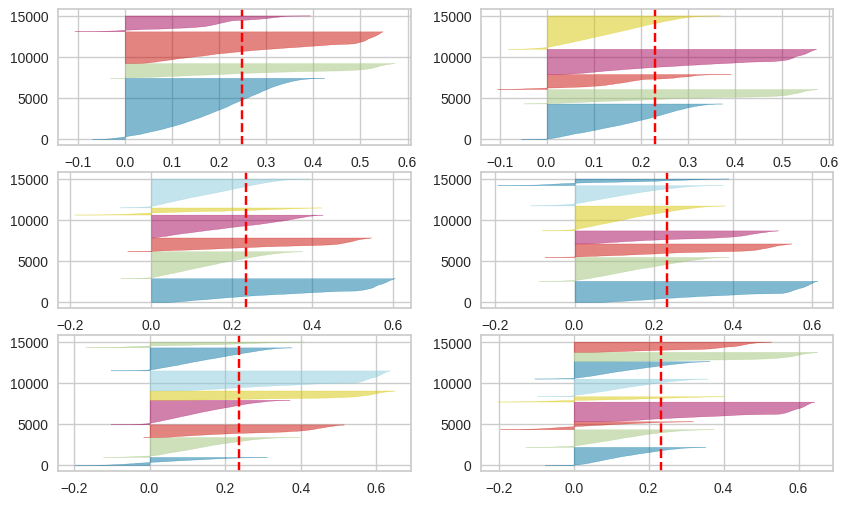

In [ ]:
# Veamos también el método Silhouette a ver que nos dice:

fig, ax = plt.subplots(3, 2, figsize=(10,6))                            # tarda como 1 min

for i in [4,5,6,7,8,9]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=7)
    q, mod = divmod(i-2, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(pca_df_T)

De ambos análisis/gráficos observamos varias opciones, pero para fines de este ejercicio seleccionaremos el valor de 5 para la cantidad de cúmulos que consideamos más adecuada con estos 6 vectores de componentes principales que generamos.

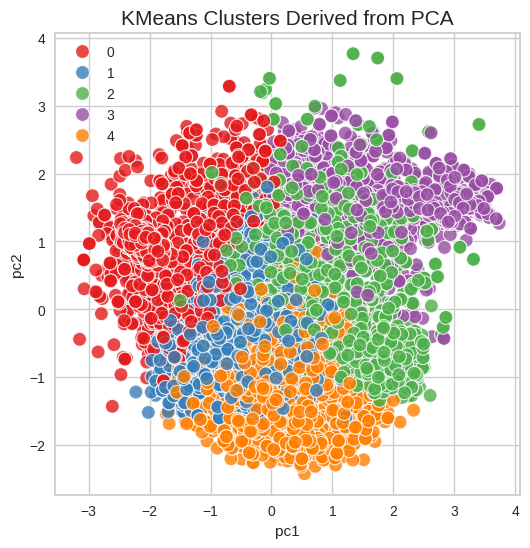

In [ ]:
kmeans_pca_T = KMeans(n_clusters=5, n_init=7, max_iter=400, init='k-means++').fit(pca_df_T)

labels_pca_T = kmeans_pca_T.labels_

clusters_pca_T = pd.concat([pca_df_T, pd.DataFrame({'pca_clusters':labels_pca_T})], axis=1)



# Grafiquemos las primeras 2 componentes principales del método PCA :
plt.figure(figsize = (6,6))
sns.scatterplot(x=clusters_pca_T['pc1'],
                y=clusters_pca_T['pc2'],
                hue=labels_pca_T,
                palette='Set1',
                s=100,
                alpha=0.8
                ).set_title('KMeans Clusters Derived from PCA', fontsize=15)

plt.legend()
plt.show()

In [ ]:
# Concatenamos ahora el dataFrame de datos originales con los cúmulos identificados
# mediante las componentes principales de los datos de entrada:

cluster_pca_perfiles = pd.concat([dftodos, pd.DataFrame(clusters_pca_T['pca_clusters'])], axis=1 )
cluster_pca_perfiles.head().T

0      1       2       3      4
satisfaction_level      0.09   0.38     0.8    0.11   0.72
last_evaluation         0.36   0.53    0.86    0.88   0.87
number_project             2      2       5       7      5
average_montly_hours      96    157     262     272    223
time_spend_company         2      3       6       4      5
Work_accident              0      0       0       0      0
promotion_last_5years      0      0       0       0      0
sales                  sales  sales   sales   sales  sales
salary                   low    low  medium  medium    low
pca_clusters               0      0       2       3      2

# **Relaciones entre factores de acuerdo a los cúmulos**

In [ ]:
fact1 = 'last_evaluation'
fact2 = 'satisfaction_level'

mi_scatterplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

In [ ]:
box = (cluster_Z_latent_perfiles['last_evaluation'] < 0.56 ) & (cluster_Z_latent_perfiles['last_evaluation'] > 0.44) & (cluster_Z_latent_perfiles['satisfaction_level'] < 0.47 ) & (cluster_Z_latent_perfiles['satisfaction_level'] > 0.36)

cluster_Z_latent_perfiles[box]

satisfaction_level  last_evaluation  number_project  \
1                    0.38             0.53               2   
5                    0.37             0.52               2   
6                    0.41             0.50               2   
10                   0.42             0.53               2   
11                   0.45             0.54               2   
...                   ...              ...             ...   
14989                0.46             0.55               2   
14993                0.40             0.48               2   
14996                0.37             0.48               2   
14997                0.37             0.53               2   
14999                0.37             0.52               2   

       average_montly_hours  time_spend_company  Work_accident  \
1                       157                   3              0   
5                       159                   3              0   
6                       153                   3              0   
10                      142                   3              0   
11                      135                   3              0   
...                     ...                 ...            ...   
14989                   145                   3              0   
14993                   155                   3              0   
14996                   160                   3              0   
14997                   143                   3              0   
14999                   158                   3              0   

       promotion_last_5years      sales salary  autoencoder_clusters  
1                          0      sales    low                     2  
5                          0      sales    low                     2  
6                          0      sales    low                     2  
10                         0      sales    low                     2  
11                         0      sales    low                     2  
...                      ...        ...    ...                   ...  
14989                      0  technical    low                     2  
14993                      0    support    low                     2  
14996                      0    support    low                     2  
14997                      0    support    low                     2  
14999                      0    support    low                     2  

[1315 rows x 10 columns]

# **Ejercicio - 3:**

### **Con base a los gráficos dados en los siguientes pares de factores y en relación a los subgrupos o cúmulos observados por el método de Autoencoders y el de PCA, incluye alguna interpretación del mismo que ayude a entender mejor al departamento de recursos humanos el ambiente de trabajo dentro de la empresa.**

In [ ]:
# Ejercicio 3a:


fact1 = 'last_evaluation'
fact2 = 'average_montly_hours'

mi_scatterplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3a:**

Con ambos métodos, podemos identificar que hay un grupo definido de personas que tienen un puntaje en su última evaluación por debajo de 0.6 y que además tienen un promedio de horas mensuales de trabajo en la empresa menor a 160 horas, y por el contrario, hay un grupo definido de personas con un promedio superior a 250 horas promedio y con una evaluación superior a 0.80 lo que podría indicar que las horas promedio trabajadas en la empresa influyen en la evaluación de los empleados o en su rendimiento pues a más horas trabajadas los trabajadores pueden estar generando mejores resultados en cuanto a productividad. Sin embargo, también es posible observar otras dos agrupaciones en la gráfica de PCA: de trabajadores que tienen un puntaje en su ultima evaluación inferior a 0.7 y que tienen horas promedio de trabajo desde 150 hasta 280 horas; y de trabajadores en el mismo rango de horas pero con una evaluación superior a 0.7. En general, lo ideal sería poner atención a aquellos trabajadores con un promedio bajo de horas trabajadas y con una evaluación baja ya que son quienes pueden estar menos comprometidos con sus labores.


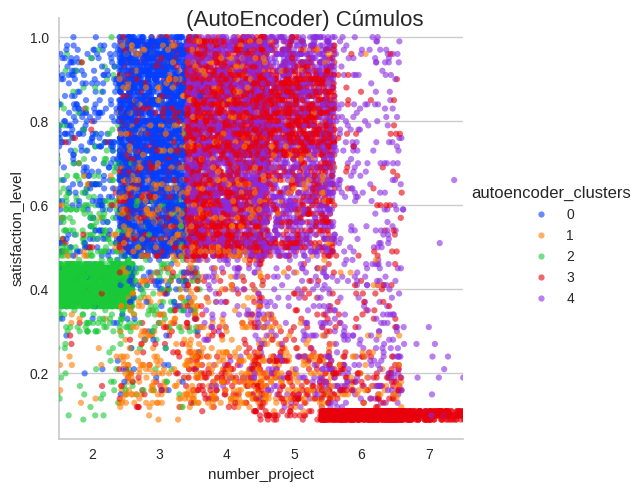

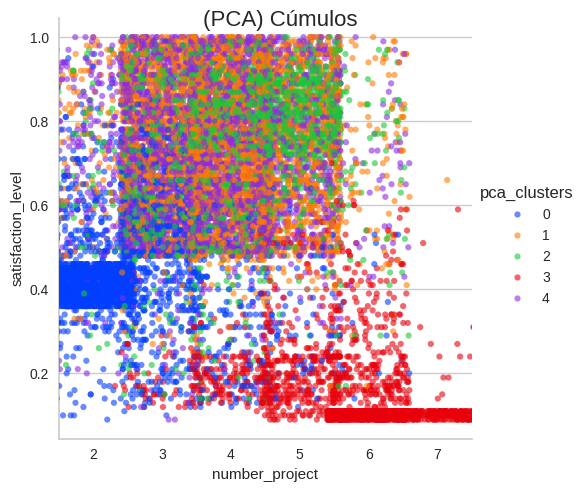

In [ ]:
# Ejercicio 3b:


fact1 = 'number_project'
fact2 = 'satisfaction_level'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3b:**

De estos gráficos, llaman la atención tres cumulos en partícular muy definidos en ambos métodos: aquellos con más 5 proyectos y un nivel de satisfacción inferior al 0.2 en el que parece que la carga laborar está impactando en la satisfacción de los empleados. Otro cumulo donde hay trabajadores con menos de tres proyectos y un nivel de satisfacción que ronda el 0.4, donde también una baja carga laborar impacta en la satisfacción.
Y un tercer cumulo, el cual sería la carga ideal de trabajo: entre 3 y 5 proyectos, en donde la stisfacción de los empleados va del 0.5 en adelante.


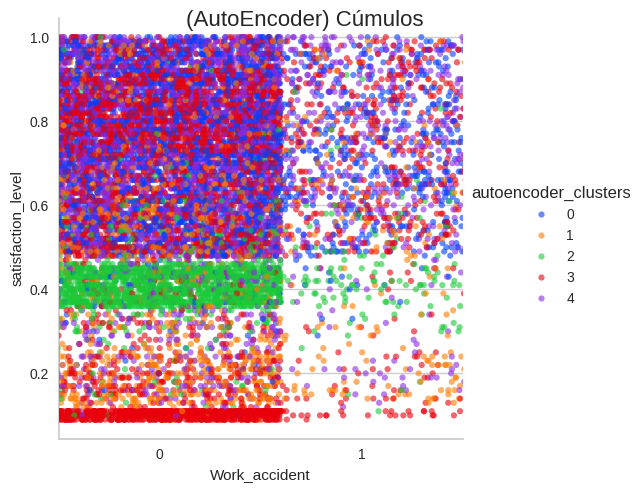

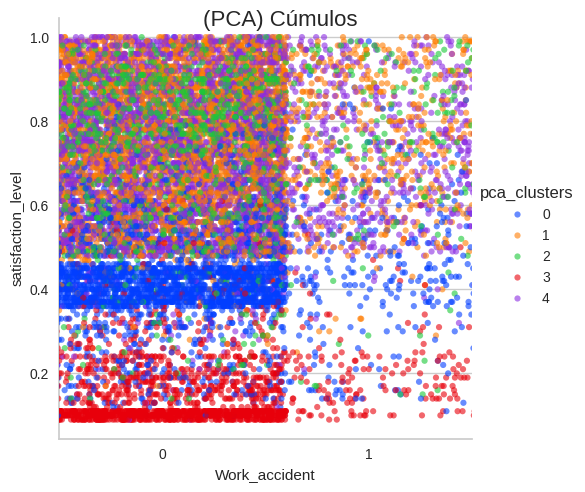

In [ ]:
# Ejercicio 3c:


fact1 = 'Work_accident'
fact2 = 'satisfaction_level'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3c:**

Podemos destacar que hay trabajadores que no han tenido accidentes laborales que se encuentran agrupados en tres niveles de satisfacción: el cumulo más grande, con niveles de satisfacción superiores al 0.5. Un cumulo de trabajadores con un nivel de satisfacción que ronda el 0.4 y un cumulo de trabajadores con un nivel de satisfacción inferior a 0.2. Lo que llama la atención es que hay un solo cumulo de trabajadores que han tenido accidente pero que su nivel de satisfacción es superior a 0.5. Esto podría indicar que aquellos quienes han tenido un accidente laboral han sido atendidos adecuadamente por la empresa y por eso están satisfechos, mienstras que quienes no han tenido un accidente, este hecho por sí mismo, no es un factor para que haya personas satifechas o insatifechas ya que hay cumulos en todos los niveles de satisfacción.


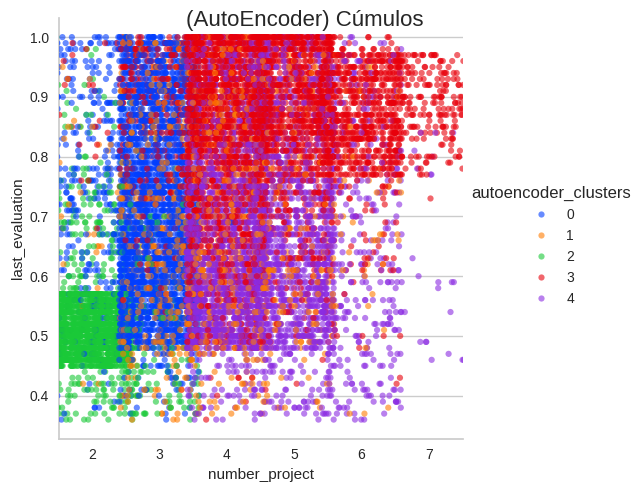

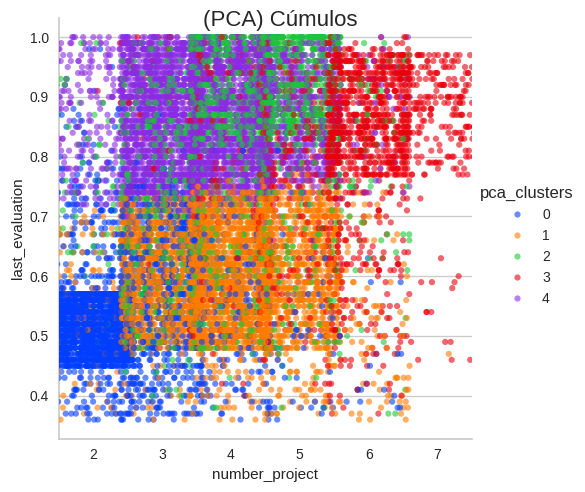

In [ ]:
# Ejercicio 3d:

fact1 = 'number_project'
fact2 = 'last_evaluation'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3d:**


De esta gráfica vale la pena destacar dos cumulos o grupos: uno en el cual su ultima evaluación fue superior al 0.7 y tienen más de 5 proyectos.Y otro en el cuál su ultima evaluación está entre 0.5 y 0.6 y tienen entre 2 y 3 proyectos. De aquí podemos destacar que el numero de proyectos tiene cierta influencia en la evaluación de los trabajadores: entre más proyectos, mejor evaluación. Sin embargo, se podría trabajar en agrupar a las personas entre 3 y 5 proyectos, pues también hay un cumulo en PCA donde está muy bien definido este rango y las evaluaciones son superiores a 0.7. Aunque vale la pena mencionar que hay otro cumulo de personas en el mismo rango de proyectos con una calificación entre 0.7 y 0.5, donde también vale la pena identificar porque su evaluación esta en dichos niveles, ya que el numero de proyectos en este caso, no sería un factor de acuerdo a la lógica que exponen los demás cumulos.


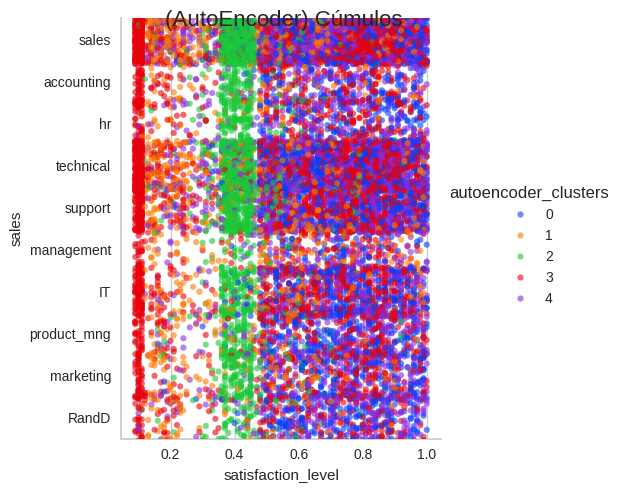

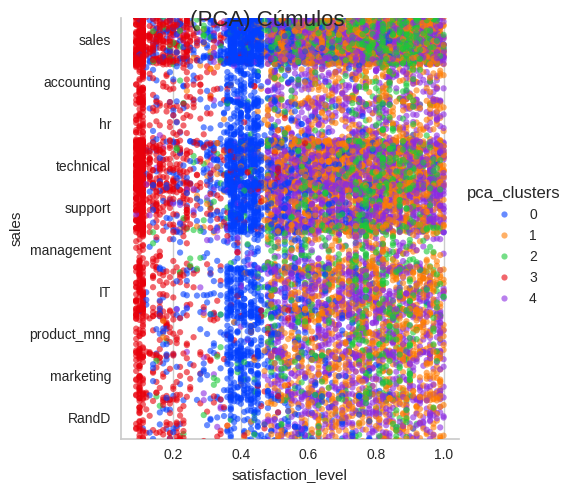

In [ ]:
# Ejercicio 3e:

fact2 = 'sales'
fact1 = 'satisfaction_level'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3e:**


En general, es posible observar que hay de todos los niveles de satisfacción en todos los departamentos de la empresa pues se pueden observar cumulos en bandas que se traslapan entre ellas. Es decir, no es posible identificar un departamento en particular que tenga bajos niveles de satisfacción que requiera de atención inmediata. Por otra parte, si es posible destacar que los mayores cumulos se presentan en todos los departamentos con niveles de satisfacción superiores a 0.6. En resumen, el departamento al que pertenece el trabajador no parecer ser motivo de insatisfacción, por lo que se deben estudiar aquellos cumulos de baja satisfacción con otros factores que no sean el departamento.

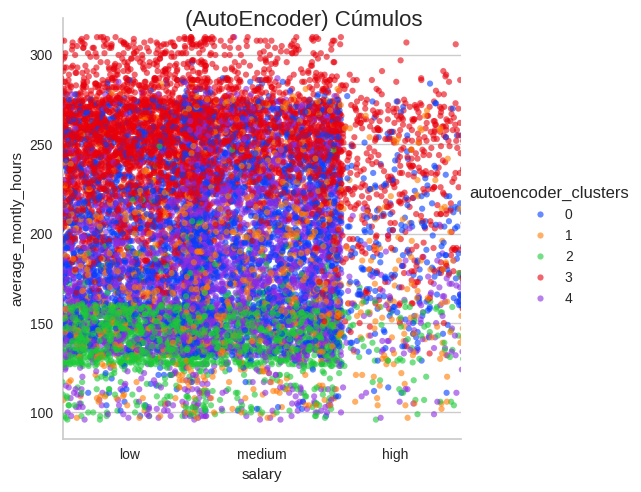

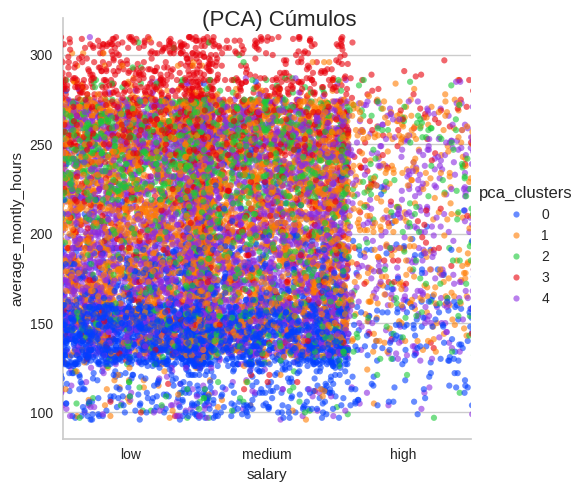

In [ ]:
# Ejercicio 3f:


fact1 = 'salary'
fact2 = 'average_montly_hours'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)

## **Ejercicio 3f:**


Podemos observar que hay 3 cumulos definidos tanto en las bandas salariales bajas y medias, hay un cumulo en cada banda que ronda en las 150 horas promedio de trabajo en la empresa, el cumulo más grande entre 150 y 280 horas promedio y finalmente un cumulo con más de 280 horas trabajadas. Lo que esto nos indica es que las horas promedio trabajadas en la empresa no tienen un relación directa con el nivel salarial, pues peudes encontrar promedios de horas bajos con salario bajo o promedios de horas bajo con un salario alto. En general, podemos decir que la empresa no define bandas salariales de acuerdo a las horas promedio de trabajo de un trabajador, sino que tiene que ver con otros factores.


## **Ejercicio 3g:**

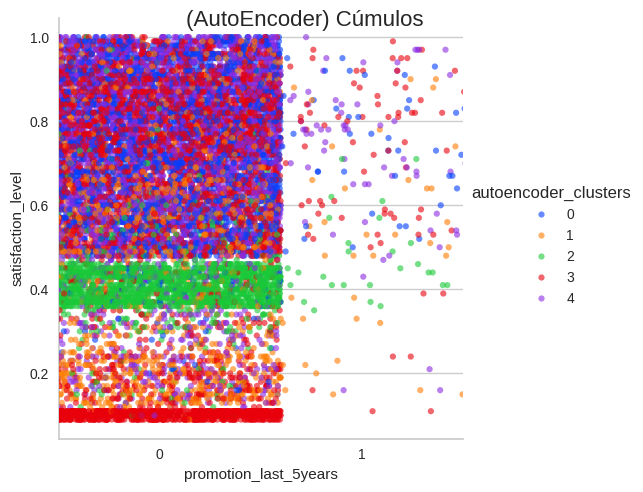

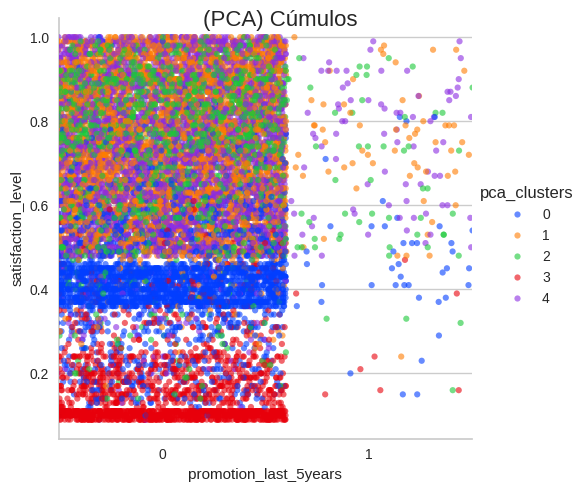

In [ ]:
# Incluye algún otro gráfico y tus comentarios de otra relación entre variables
# que consideres proporcione información importante al problema.

fact1 = 'promotion_last_5years'
fact2 = 'satisfaction_level'

mi_catplotPCAEncoder(cluster_Z_latent_perfiles, cluster_pca_perfiles, fact1, fact2)


Uno de los factores que es interesante estudiar es la relación que hay entre la satisfacción del empleado de acuerdo a las promociones que tenga, pues el crecimiento es importante para un trabajador en su carrera profesional y/o laboral. En este caso podemos observar que todos los cumulos se encuentran en las personas que no hay tenido promoción, esto se puede deber a que no hay muchas posibilidades de promoción en la empresa y puede que no sea un factor relevante para la satisfacción debido a que el cumulo más grande se encuentra en niveles superiores al 0.5. Sin embargo, podría ser interesante investigar más a profundidad si el cumulo que ronda el 0.4 y aquel en niveles menores a 0.2 tienen su origen en que esos trabajadores no hayan tenido promoción.



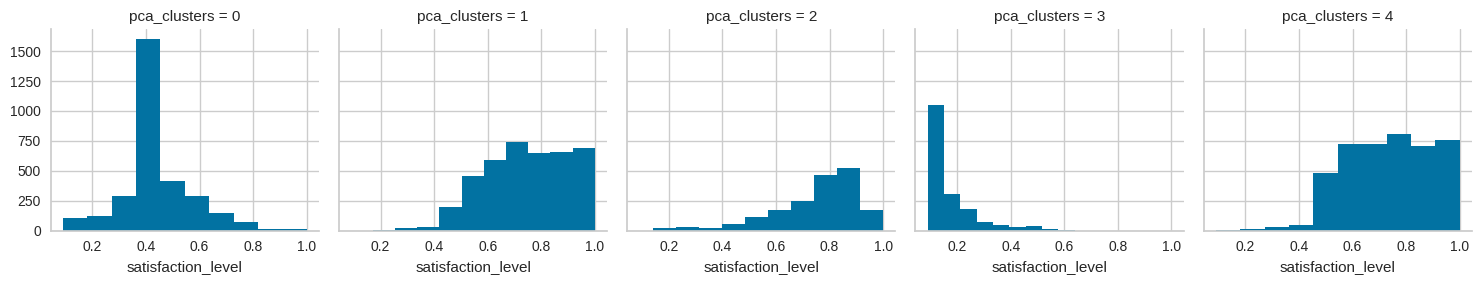

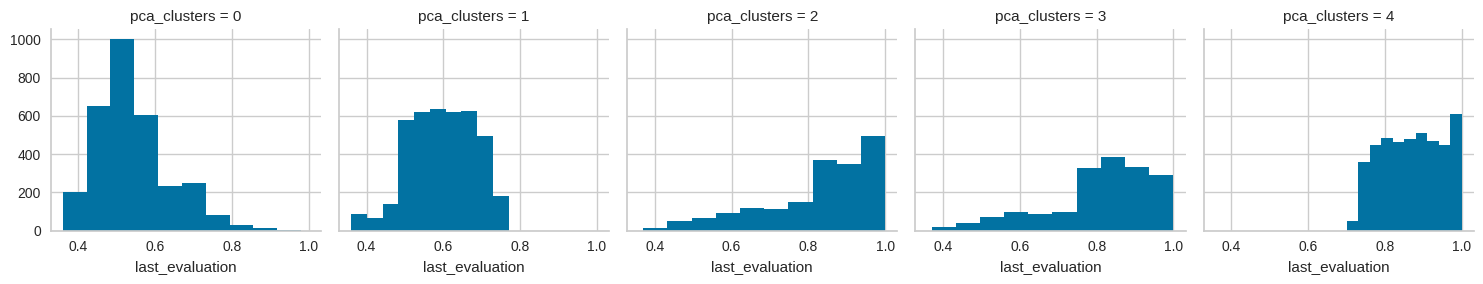

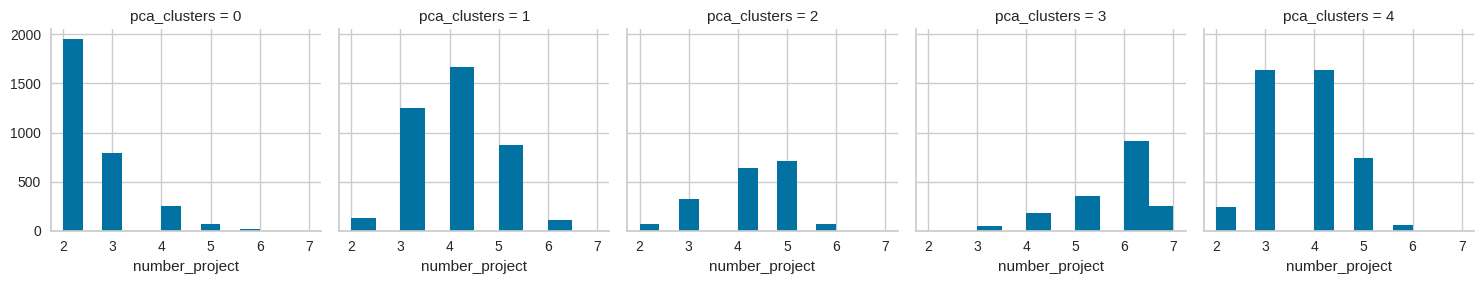

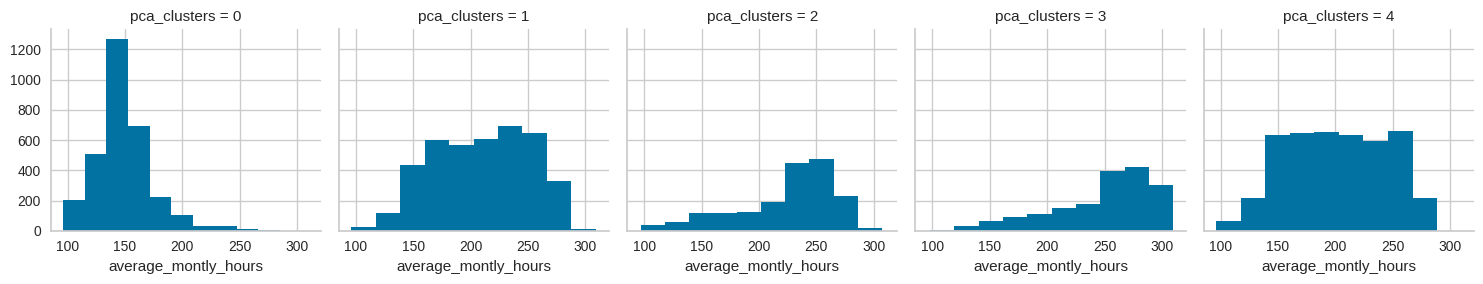

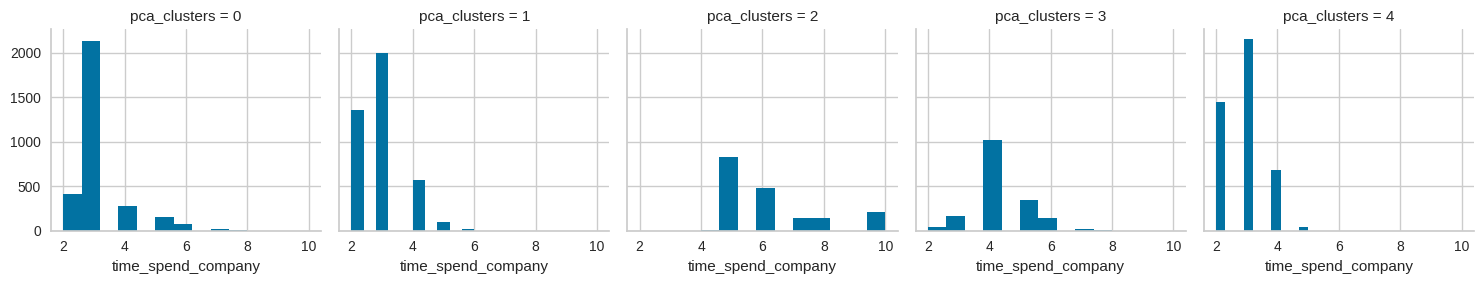

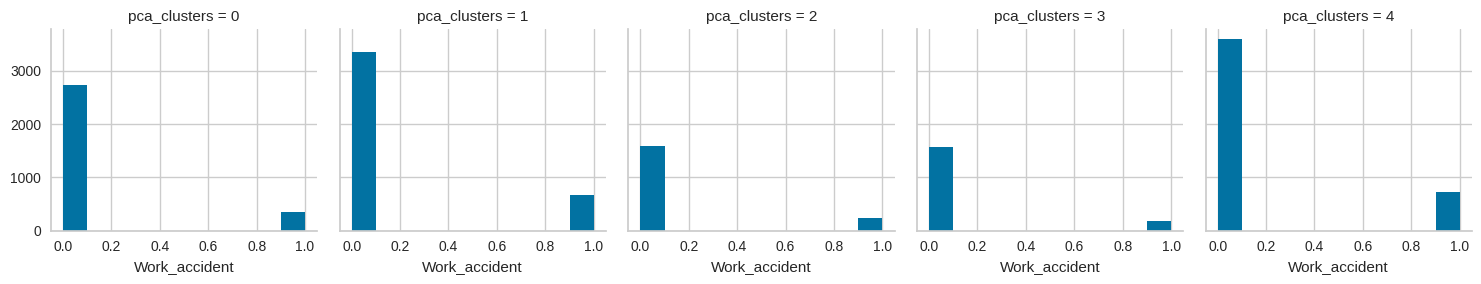

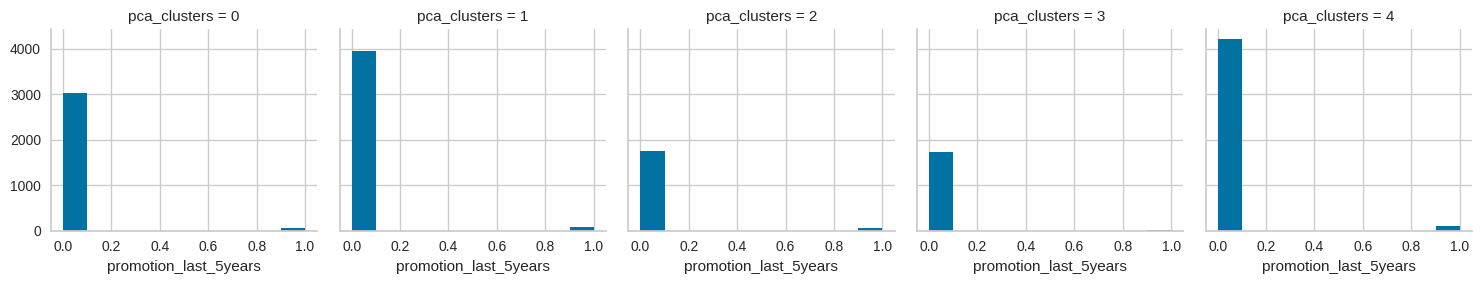

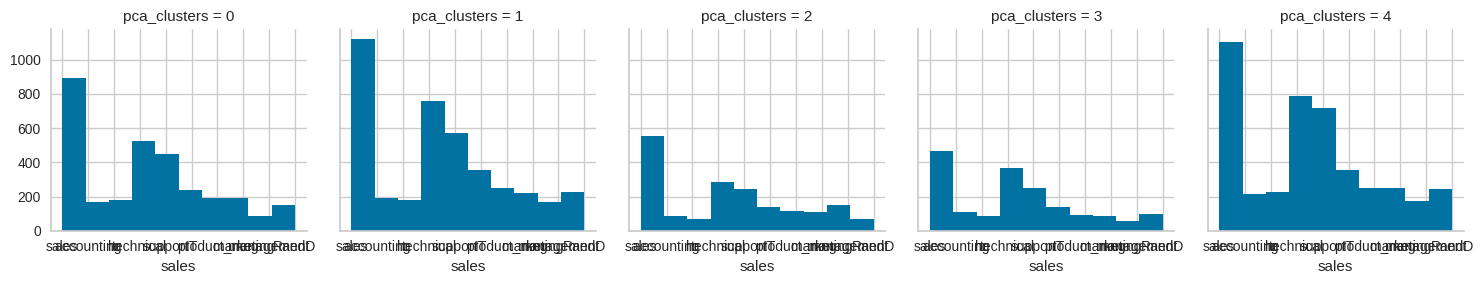

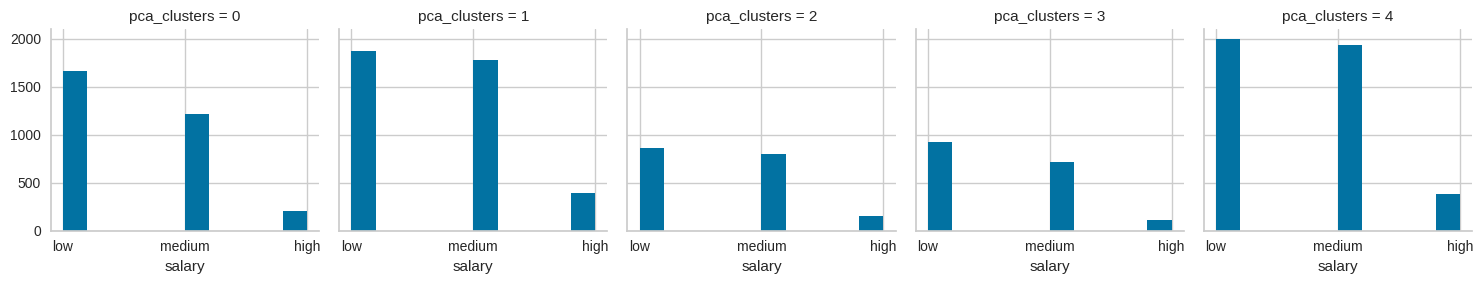

In [ ]:
# Podemos obtener algunos diagramas adicionales que nos ayuden a entender
# mejor cada cúmulo y su relación con los factores que la forman.
# Sabemos que exiten una gran variedad de otros tipos e gráficos.
# En particular podemos mostrar los de los cúmulos obtenidos con el método
# de autoencoders solo como muestra y a manera de complemento de la
# información que hemos obtenida con los gráficos anteriores:

for c in cluster_pca_perfiles.iloc[:,:9]:
    grid = sns.FacetGrid(cluster_pca_perfiles, col='pca_clusters')
    grid.map(plt.hist, c)

# **Ejercicio - 4:**

#### **Incluye tus conclusiones y comentarios finales de la Actividad:**

Los métodos de clustering y reducción de dimensionalidad son algoritmos muy potentes para identificar patrones y agrupar datos cuando estos no se encuentran etiquetados. En general, el aprendizaje no supervisado en combinación con un conocimiento profundo del negocio pueden ser una herramienta de optimización de procesos o resolución de conflictos de alto impacto dentro de una organización. Por ejemplo, el analisis del personal, tal como se estudio en esta actividad, puede llevar a estrategias que aumenten la satisfacción de los trabajadores y su productividad y con ello mejorar los resultados económicos y organizacionales en el corto y mediano plazo. Pero también se pueden aplicar este tipo de técnicas en áreas más operativas como la logística, el aprovechamiento de los recursos en la producción, en el manejo de las finanzas y en la segmentación de cliente para mejorar las ventas por mencionar algunos ejemplos.

En particular, sobre los algoritmos estudidados, podemos identificar que tanto autoencoders como PCA funcionaron de manera óptima, pero es conveniente decir que el algortimo de PCA definió muy bien los grupos, con lo cual podemos afirmar que un modelo más complejo no siempre es mejor. Esto lo podemos observar en las comparativas de ambos algoritmos al analizar los diversos factores, pues el alrgoritmo PCA logra segmentar igual y en algunos casos un poco mejor los cumulos. Finalmente, mencionar que la técnica Silhouette es un buen complemento para afirmar el número de cluster a elegir aunque se pueden aplicar otras técnicas como GridSearchCV como complemento para definir el numero óptimo de clusters.


>> **++++ Fin del la Actividad de la Semana de Autoencoders ++++**